# Yelp Dataset preprocessing by ASAC

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install polars

In [ ]:
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt

## Open Dataset

In [ ]:
user_df = pl.read_ndjson("/content/drive/MyDrive/ASAC 5기/woowahan/dataset/yelp_academic_dataset_user.json")

In [ ]:
biz_df = pl.read_ndjson("/content/drive/MyDrive/ASAC 5기/woowahan/dataset/yelp_academic_dataset_business.json")

In [ ]:
review_df = pl.read_ndjson("/content/drive/MyDrive/ASAC 5기/woowahan/dataset/yelp_academic_dataset_review.json")

In [ ]:
area_df = pl.read_csv("/content/drive/MyDrive/ASAC 5기/woowahan/dataset/active_area.csv")

In [ ]:
## polar to pandas
user_df = user_df.to_pandas()
biz_df = biz_df.to_pandas()
review_df = review_df.to_pandas()
area_df = area_df.to_pandas()

In [ ]:
biz_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150346 entries, 0 to 150345
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   business_id   150346 non-null  object 
 1   name          150346 non-null  object 
 2   address       150346 non-null  object 
 3   city          150346 non-null  object 
 4   state         150346 non-null  object 
 5   postal_code   150346 non-null  object 
 6   latitude      150346 non-null  float64
 7   longitude     150346 non-null  float64
 8   stars         150346 non-null  float64
 9   review_count  150346 non-null  int64  
 10  is_open       150346 non-null  int64  
 11  attributes    0 non-null       object 
 12  categories    150243 non-null  object 
 13  hours         0 non-null       object 
dtypes: float64(3), int64(2), object(9)
memory usage: 16.1+ MB


##  Label Encoding id values

* review_df 테이블의 user_id, business_id, review_id를 기준으로 인코더 생성 및 인코딩
* 이후 user_df와 biz_df 테이블에 동일한 인코더 적용하여 인코딩

In [ ]:
print("유저 테이블 유저 수 : ")
print(user_df['user_id'].nunique())

print("리뷰 테이블 유저 수 : ")
print(review_df['user_id'].nunique())

print("비즈니스 테이블 비즈니스 수 : ")
print(biz_df['business_id'].nunique())

print("리뷰 테이블 비즈니스 수 : ")
print(review_df['business_id'].nunique())

유저 테이블 유저 수 : 
1987897
리뷰 테이블 유저 수 : 
1987929
비즈니스 테이블 비즈니스 수 : 
150346
리뷰 테이블 비즈니스 수 : 
150346


In [ ]:
## 각 df의 id값 인코딩 함수

from sklearn.preprocessing import LabelEncoder

def label_encode_column(df, column, encoder=None):
    if encoder is None:
        encoder = LabelEncoder()
        df[column] = encoder.fit_transform(df[column])
    else:
        df[column] = encoder.transform(df[column])
    return encoder

In [ ]:
## review_df의 id값 인코딩 적용 후 user_id와 biz_id에도 동일한 인코더 적용

def encode_review_data(review_df, user_df, biz_df):
    # 라벨 인코더 초기화
    user_encoder = label_encode_column(review_df, 'user_id')
    biz_encoder = label_encode_column(review_df, 'business_id')
    review_encoder = label_encode_column(review_df, 'review_id')

    # 리뷰 데이터프레임에 인코더 적용
    label_encode_column(user_df, 'user_id', user_encoder)
    label_encode_column(biz_df, 'business_id', biz_encoder)

    return review_df, user_df, biz_df

In [ ]:
# 함수 호출
encoded_review_df, encoded_user_df, encoded_biz_df = encode_review_data(review_df, user_df, biz_df)

## Filtering business categories

* categories 컬럼 전처리
* main/sub라는 새로운 컬럼 생성
* main1과 main2가 'Restaurants'와 'Food'인 경우로 필터링

### categories 컬럼 전처리

In [ ]:
encoded_biz_df["categories"][141]  # 확인

'Live/Raw Food, Restaurants, Seafood, Beer Bar, Beer, Wine & Spirits, Bars, Food, Nightlife'

In [ ]:
## 1. categories 컬럼 전처리

# split 및 공백처리
encoded_biz_df = encoded_biz_df.dropna(subset=["categories"])  # 카테고리 없는 행 제거
encoded_biz_df["categories"] = encoded_biz_df["categories"].str.split(",").apply(lambda x  :  [i.strip() for i in x] if x != None else x)

# Food에서 "Beer, Wine & Spirits"는 하나로 합쳐줘야 함
try :
  for idx, row in encoded_biz_df.iterrows() :
    for i in range(len(row["categories"])) :
      if row["categories"][i] == "Beer" :
        row["categories"][i] = "Beer, Wine & Spirits"
        del row["categories"][i+1]
        encoded_biz_df.at[idx, "categories"] = row["categories"]
        break
except : # category None인 경우
  pass

# encoded_biz_df["categories"][141]  # 확인

<ipython-input-15-249bc01628f3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  encoded_biz_df["categories"] = encoded_biz_df["categories"].str.split(",").apply(lambda x  :  [i.strip() for i in x] if x != None else x)


In [ ]:
encoded_biz_df["categories"][141]  # 확인

['Live/Raw Food',
 'Restaurants',
 'Seafood',
 'Beer Bar',
 'Beer, Wine & Spirits',
 'Bars',
 'Food',
 'Nightlife']

### main / sub 파생변수 생성

In [ ]:
## yelp_categories.json load
import json

cat_path = "/content/drive/MyDrive/ASAC 5기/woowahan/dataset/yelp_categories.json"  # 경로 변경
with open( cat_path, 'r') as file:
  yelp_cat = json.load(file)

In [ ]:
## 카테고리 딕셔너리 생성 함수
def create_category_dict(yelp_cat):
    category = {c["title"]: {"alias": c["alias"], "subs": []} for c in yelp_cat if not c["parents"]}
    for c in yelp_cat:
        if c["parents"]:
            for title, info in category.items():
                if info["alias"] == c["parents"][0] and c["title"] not in info["subs"]:
                    info["subs"].append(c["title"])
    return category


In [ ]:
## 메인 카테고리 추출 함수(최대 2개)
def extract_main_categories(business, category):
    main1, main2 = [], []
    cat_set = list(category.keys())
    for cats in business["categories"]:
        temp = [cat for cat in cats if cat in cat_set]
        main1.append(temp[0] if temp else None)
        main2.append(temp[1] if len(temp) > 1 else None)
    return main1, main2

In [ ]:
## 서브 카테고리 추출 함수
def extract_subcategories(business, category, main1, main2):
    def process_subcategories(temp):
        if len(temp) >= 2:
            return (temp[0], temp[1])
        elif temp:
            return (temp[0], None)
        else:
            return (None, None)

    main1_sub1, main1_sub2 = [], []
    main2_sub1, main2_sub2 = [], []

    for i, row in business.iterrows():
        main1_subs = category[row["main1"]]["subs"] if row["main1"] else []
        main2_subs = category[row["main2"]]["subs"] if row["main2"] else []

        temp1 = [cat for cat in row["categories"] if cat in main1_subs]
        temp2 = [cat for cat in row["categories"] if cat in main2_subs]

        main1_sub = process_subcategories(temp1)
        main2_sub = process_subcategories(temp2)

        main1_sub1.append(main1_sub[0])
        main1_sub2.append(main1_sub[1])
        main2_sub1.append(main2_sub[0])
        main2_sub2.append(main2_sub[1])

    return main1_sub1, main1_sub2, main2_sub1, main2_sub2


In [ ]:
## 함수 적용
category_dict = create_category_dict(yelp_cat)
main1, main2 = extract_main_categories(encoded_biz_df, category_dict)
encoded_biz_df["main1"], encoded_biz_df["main2"] = main1, main2

main1_sub1, main1_sub2, main2_sub1, main2_sub2 = extract_subcategories(encoded_biz_df, category_dict, main1, main2)
encoded_biz_df["main1_sub1"], encoded_biz_df["main1_sub2"], encoded_biz_df["main2_sub1"], encoded_biz_df["main2_sub2"] = main1_sub1, main1_sub2, main2_sub1, main2_sub2

encoded_biz_df.info()

<ipython-input-21-8bed2c9efd82>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  encoded_biz_df["main1"], encoded_biz_df["main2"] = main1, main2
<ipython-input-21-8bed2c9efd82>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  encoded_biz_df["main1"], encoded_biz_df["main2"] = main1, main2


<class 'pandas.core.frame.DataFrame'>
Index: 150243 entries, 0 to 150345
Data columns (total 20 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   business_id   150243 non-null  int64  
 1   name          150243 non-null  object 
 2   address       150243 non-null  object 
 3   city          150243 non-null  object 
 4   state         150243 non-null  object 
 5   postal_code   150243 non-null  object 
 6   latitude      150243 non-null  float64
 7   longitude     150243 non-null  float64
 8   stars         150243 non-null  float64
 9   review_count  150243 non-null  int64  
 10  is_open       150243 non-null  int64  
 11  attributes    0 non-null       object 
 12  categories    150243 non-null  object 
 13  hours         0 non-null       object 
 14  main1         150243 non-null  object 
 15  main2         55843 non-null   object 
 16  main1_sub1    143791 non-null  object 
 17  main1_sub2    63205 non-null   object 
 18  main2_sub

<ipython-input-21-8bed2c9efd82>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  encoded_biz_df["main1_sub1"], encoded_biz_df["main1_sub2"], encoded_biz_df["main2_sub1"], encoded_biz_df["main2_sub2"] = main1_sub1, main1_sub2, main2_sub1, main2_sub2
<ipython-input-21-8bed2c9efd82>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  encoded_biz_df["main1_sub1"], encoded_biz_df["main1_sub2"], encoded_biz_df["main2_sub1"], encoded_biz_df["main2_sub2"] = main1_sub1, main1_sub2, main2_sub1, main2_sub2
<ipython-input

### main1 / main2가 'Restaurants' or 'Food'인 비즈니스만 필터링

In [ ]:
## Restaurants, Food 필터링 함수

def filter_business_by_main_category(business, categories=["Restaurants", "Food"]):
    condition = (business["main1"].isin(categories)) | (business["main2"].isin(categories))
    return business[condition]

In [ ]:
## main1의 sub가 비었을 경우, main2가 res,food인 데이터 사용 함수

def determine_optimal_category(biz_res_fd):
    col = []
    for i, row in biz_res_fd.iterrows():
        if pd.isna(row["main1_sub1"]) and row["main2"] in ["Restaurants", "Food"] and pd.notna(row["main2_sub1"]):
            col.append([row["main2"], row["main2_sub1"]])
        elif row["main1"] not in ["Restaurants", "Food"] and row["main2"] in ["Restaurants", "Food"]:
            col.append([row["main2"], row["main2_sub1"]])
        else:
            col.append([row["main1"], row["main1_sub1"]])
    biz_res_fd["category"] = col
    return biz_res_fd

In [ ]:
## Nan값 필터링 함수

def filter_out_nan_categories(biz_res_fd):
    condition = biz_res_fd['category'].apply(lambda x: pd.isna(x[1]))
    return biz_res_fd[~condition]

In [ ]:
## 함수 적용
filtered_business = filter_business_by_main_category(encoded_biz_df)
optimized_categories = determine_optimal_category(filtered_business)
encoded_biz_df_filter_cat = filter_out_nan_categories(optimized_categories)

<ipython-input-23-7f69464412db>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  biz_res_fd["category"] = col


In [ ]:
# 결과 출력
encoded_biz_df_filtered = encoded_biz_df_filter_cat.drop(columns=['categories','main1', 'main2', 'main1_sub1','main1_sub2','main2_sub1','main2_sub2'],axis=1)

In [ ]:
encoded_biz_df_filtered

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,hours,category
3,55038,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,None,None,"[Food, Bubble Tea]"
4,118460,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,None,None,"[Food, Breweries]"
5,31395,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,6,1,None,None,"[Food, Ice Cream & Frozen Yogurt]"
8,112608,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,MO,63123,38.565165,-90.321087,3.0,19,0,None,None,"[Restaurants, Italian]"
9,91812,Sonic Drive-In,2312 Dickerson Pike,Nashville,TN,37207,36.208102,-86.768170,1.5,10,1,None,None,"[Restaurants, Fast Food]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150327,94529,Dutch Bros Coffee,1181 N Milwaukee St,Boise,ID,83704,43.615401,-116.284689,4.0,33,1,None,None,"[Restaurants, Cafes]"
150328,6598,Savaya Coffee Market,11177 N Oracle Rd,Oro Valley,AZ,85737,32.409552,-110.943073,4.5,41,1,None,None,"[Food, Specialty Food]"
150336,79263,Adelita Taqueria & Restaurant,1108 S 9th St,Philadelphia,PA,19147,39.935982,-75.158665,4.5,35,1,None,None,"[Restaurants, Mexican]"
150339,8107,The Plum Pit,4405 Pennell Rd,Aston,DE,19014,39.856185,-75.427725,4.5,14,1,None,None,"[Restaurants, Comfort Food]"


## Filtering review df

* 2017 ~ 2021 로 기간한정

* business_df의 카테고리로 필터링



### 기간 필터링

In [ ]:
encoded_review_df['date'].unique()

array(['2018-07-07 22:09:11', '2012-01-03 15:28:18',
       '2014-02-05 20:30:30', ..., '2019-12-30 03:56:30',
       '2022-01-19 18:59:27', '2018-01-02 22:50:47'], dtype=object)

In [ ]:
# 날짜 형식 변경
encoded_review_df['date'] = pd.to_datetime(encoded_review_df['date'], format='%Y-%m-%d %H:%M:%S')

# 특정 연도 범위 데이터 필터링
start, end = 2017, 2021
encoded_review_df_filtered_date = encoded_review_df[(encoded_review_df['date'].dt.year >= start) & (encoded_review_df['date'].dt.year <= end)]

In [ ]:
encoded_review_df_filtered_date['date'].unique()

<DatetimeArray>
['2018-07-07 22:09:11', '2017-01-14 20:54:15', '2018-07-17 03:30:07',
 '2017-02-19 13:32:05', '2017-01-02 03:17:34', '2017-05-26 13:10:24',
 '2017-05-13 14:15:29', '2017-09-20 16:16:47', '2018-08-23 21:39:38',
 '2018-04-27 23:03:21',
 ...
 '2019-03-27 04:16:27', '2017-10-22 20:55:12', '2021-11-29 18:26:40',
 '2021-08-28 18:46:05', '2019-08-21 20:49:13', '2018-12-10 16:31:32',
 '2018-03-13 13:54:48', '2021-03-31 16:55:10', '2019-12-30 03:56:30',
 '2018-01-02 22:50:47']
Length: 3740333, dtype: datetime64[ns]

### 카테고리 필터링

In [ ]:
biz_list = list(encoded_biz_df_filtered["business_id"])
encoded_review_df_filtered  = encoded_review_df_filtered_date[encoded_review_df_filtered_date["business_id"].isin(biz_list)]
encoded_review_df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2680161 entries, 0 to 6990279
Data columns (total 9 columns):
 #   Column       Dtype         
---  ------       -----         
 0   review_id    int64         
 1   user_id      int64         
 2   business_id  int64         
 3   stars        float64       
 4   useful       int64         
 5   funny        int64         
 6   cool         int64         
 7   text         object        
 8   date         datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(6), object(1)
memory usage: 204.5+ MB


## Create active_area DataFrame

* biz_df 의 city + postal_code를 이용한 region 컬럼 생성

* review 테이블에 region 컬럼을 join 하여 user별 최빈값 count


### Create 'region' col to review table

In [ ]:
# 새로운 region 컬럼 생성 (city와 postal_code 결합)
encoded_biz_df_filtered['region'] = encoded_biz_df_filtered['city'] + ', ' + encoded_biz_df_filtered['postal_code'].astype(str)

In [ ]:
encoded_biz_df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 62586 entries, 3 to 150340
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   business_id   62586 non-null  int64  
 1   name          62586 non-null  object 
 2   address       62586 non-null  object 
 3   city          62586 non-null  object 
 4   state         62586 non-null  object 
 5   postal_code   62586 non-null  object 
 6   latitude      62586 non-null  float64
 7   longitude     62586 non-null  float64
 8   stars         62586 non-null  float64
 9   review_count  62586 non-null  int64  
 10  is_open       62586 non-null  int64  
 11  attributes    0 non-null      object 
 12  hours         0 non-null      object 
 13  category      62586 non-null  object 
 14  region        62586 non-null  object 
dtypes: float64(3), int64(3), object(9)
memory usage: 9.7+ MB


### Join review table + 'region' column

In [ ]:
# biz_df에서 business_id와 region 컬럼만 선택
biz_region_df = encoded_biz_df_filtered[['business_id', 'region']]

biz_region_df

,business_id,region
3,55038,"Philadelphia, 19107"
4,118460,"Green Lane, 18054"
5,31395,"Ashland City, 37015"
8,112608,"Affton, 63123"
9,91812,"Nashville, 37207"
...,...,...
150327,94529,"Boise, 83704"
150328,6598,"Oro Valley, 85737"
150336,79263,"Philadelphia, 19147"
150339,8107,"Aston, 19014"


In [ ]:
biz_region_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 62586 entries, 3 to 150340
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   business_id  62586 non-null  int64 
 1   region       62586 non-null  object
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


In [ ]:
## business_id를 기준으로 review_df_select와 biz_region_df 조인

merged_biz_rev_df = pd.merge(encoded_review_df_filtered, biz_region_df, on='business_id', how='left')

In [ ]:
# 결과 확인
merged_biz_rev_df

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,region
0,2348758,1575984,80739,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11,"North Wales, 19454"
1,3273772,1231666,98537,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15,"New Orleans, 70119"
2,5406063,898460,94651,4.0,1,0,1,I was really between 3 and 4 stars for this on...,2018-07-17 03:30:07,"Indianapolis, 46268"
3,44775,644900,92221,5.0,0,0,0,First time there and it was excellent!!! It fe...,2017-02-19 13:32:05,"Eddystone, 19022"
4,3891834,177785,92778,5.0,0,0,0,"Great burgers,fries and salad! Burgers have a...",2017-01-02 03:17:34,"Goleta, 93117"
...,...,...,...,...,...,...,...,...,...,...
2680156,314518,1067060,93796,1.0,1,2,0,"The supper club is ridiculously expensive. So,...",2021-11-29 18:26:40,"Nashville, 37203"
2680157,4594911,857552,121621,4.0,1,0,0,Took a colleague here for dinner as we were tr...,2018-02-13 19:50:01,"New Orleans, 70113"
2680158,446543,1432404,67194,4.0,2,0,1,This place never fails the food is absolutely ...,2019-08-21 20:49:13,"Tampa, 33611"
2680159,4389130,722890,102240,3.0,1,1,0,This is a good pizza option - they deliver thr...,2018-03-13 13:54:48,"Philadelphia, 19103"


In [ ]:
## 최소한의 컬럼만 선택
review_join_region = merged_biz_rev_df[['review_id','user_id','business_id','region']]

In [ ]:
review_join_region

,review_id,user_id,business_id,region
0,2348758,1575984,80739,"North Wales, 19454"
1,3273772,1231666,98537,"New Orleans, 70119"
2,5406063,898460,94651,"Indianapolis, 46268"
3,44775,644900,92221,"Eddystone, 19022"
4,3891834,177785,92778,"Goleta, 93117"
...,...,...,...,...
2680156,314518,1067060,93796,"Nashville, 37203"
2680157,4594911,857552,121621,"New Orleans, 70113"
2680158,446543,1432404,67194,"Tampa, 33611"
2680159,4389130,722890,102240,"Philadelphia, 19103"


In [ ]:
import pandas as pd

# 'region' 열에서 NaN 값이 있는 행들을 필터링
nan_region_rows = review_join_region[review_join_region['region'].isna()]

# 결과 출력
print(nan_region_rows)


Empty DataFrame
Columns: [review_id, user_id, business_id, region]
Index: []


### Calculate most_visited_region & visit_count

In [ ]:
## 최빈값을 모두 리스트로 반환

def get_all_modes(x):
    value_cnt = x.value_counts()    # 빈도수 계산
    max_freq = value_cnt.max()      # 최빈값 찾기
    modes = list(value_cnt[value_cnt == max_freq].index)    # 최빈값 리스트 변환
    return modes, max_freq          # 최빈값 리스트, 빈도수 반환

def calculate_active_area_to_list(df):
    # groupby를 이용해 region 그룹화
    results = df.groupby('user_id')['region'].apply(lambda x: get_all_modes(x)).reset_index()
    # 각 그룹에 대해 get_all_modes함수 적용
    results[['most_visited_regions', 'visit_count']] = pd.DataFrame(results['region'].tolist(), index=results.index)
    results.drop(columns='region', inplace=True)
    results.columns = ['user_id', 'most_visited_regions', 'visit_count']
    return results


In [ ]:
# 함수 호출
active_area_df = calculate_active_area_to_list(review_join_region)


In [ ]:
# ## 최빈값 한개 추출

# ## group by를 통한 최빈값 계산
# def calculate_active_area(df):
#     # user_id별 region의 최빈값과 그 횟수 계산
#     most_visited = df.groupby('user_id')['region'].agg(lambda x: x.value_counts().idxmax()).reset_index()
#     visit_counts = df.groupby('user_id')['region'].agg(lambda x: x.value_counts().max()).reset_index()

#     # 결과를 병합하여 최종 데이터프레임 생성
#     active_area_df = pd.merge(most_visited, visit_counts, on='user_id')
#     active_area_df.columns = ['user_id', 'most_visited_region', 'visit_count']

#     return active_area_df

In [ ]:
# # 함수 호출
# active_area_df = calculate_active_area(review_join_region)


In [ ]:
active_area_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 974954 entries, 0 to 974953
Data columns (total 3 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   user_id               974954 non-null  int64 
 1   most_visited_regions  974954 non-null  object
 2   visit_count           974954 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 22.3+ MB


In [ ]:
active_area_df['visit_count'].value_counts()

visit_count
1      791925
2      110492
3       33967
4       14443
5        7574
        ...  
74          1
76          1
111         1
133         1
112         1
Name: count, Length: 90, dtype: int64

In [ ]:
print(active_area_df['visit_count'].describe())


count    974954.000000
mean          1.419792
std           1.678607
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         143.000000
Name: visit_count, dtype: float64


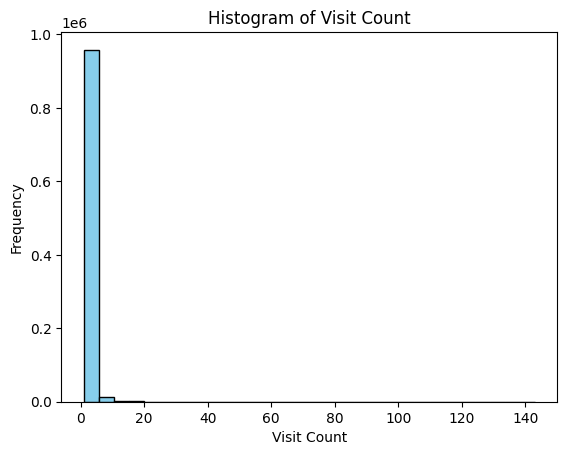

In [ ]:
import matplotlib.pyplot as plt

plt.hist(active_area_df['visit_count'], bins=30, color='skyblue', edgecolor='k')
plt.title('Histogram of Visit Count')
plt.xlabel('Visit Count')
plt.ylabel('Frequency')
plt.show()


In [ ]:
active_area_df['most_visited_regions'].iloc[352]


['Meridian, 83642', 'Meridian, 83646', 'Boise, 83709']

In [ ]:
# DF 명
# encoded_user_df
# encoded_biz_df_filtered
# encoded_review_df_filtered
# active_area_df

## Drop columns & Add new columns

* user_id 별 review_count_user, average_stars_user add

* biz_id 별 review_count_biz, average_stars_biz add

* user_df의 review_count, avg_stars drop

* biz_df의 review_count, hours drop

In [ ]:
## 함수 1 - 그룹별 리뷰 갯수 반환 함수
def add_review_count(df, encoded_review_df_filtered, group_col, count_col_name):
    # 그룹별 리뷰 개수 계산
    review_counts = encoded_review_df_filtered.groupby(group_col).size().reset_index(name=count_col_name)

    # 원본 DataFrame에 병합
    df = pd.merge(df, review_counts, how='left', on=group_col)

    # 결측값의 개수 계산
    missing_count = df[count_col_name].isna().sum()

    # 결측값의 개수를 출력
    print(f"리뷰가 없는 {group_col} 수: {missing_count}")

    # 결측값을 0으로 채움 (리뷰가 없는 경우)
    df[count_col_name].fillna(0, inplace=True)

    return df

In [ ]:
## 함수 2 - 그룹별 평균 별점 계산 함수
def calculate_avg_rating(df, group_col, rating_col, new_col_name):
    # 그룹별 평균 별점 계산
    avg_ratings = df.groupby(group_col)[rating_col].mean().reset_index(name=new_col_name)
    return avg_ratings

In [ ]:
## 1. user_id 별 리뷰 수와 별점 평균 add

# 리뷰 수 추가
encoded_user_df = add_review_count(encoded_user_df, encoded_review_df_filtered, 'user_id', 'review_count_user')

# 평균 별점 계산
avg_user_ratings = calculate_avg_rating(encoded_review_df_filtered, 'user_id', 'stars', 'average_stars_user')

# 평균 별점을 원본 DataFrame에 병합
encoded_user_df = pd.merge(encoded_user_df, avg_user_ratings, how='left', on='user_id')



리뷰가 없는 user_id 수: 1012943


In [ ]:
encoded_user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1987897 entries, 0 to 1987896
Data columns (total 24 columns):
 #   Column              Dtype  
---  ------              -----  
 0   user_id             int64  
 1   name                object 
 2   review_count        int64  
 3   yelping_since       object 
 4   useful              int64  
 5   funny               int64  
 6   cool                int64  
 7   elite               object 
 8   friends             object 
 9   fans                int64  
 10  average_stars       float64
 11  compliment_hot      int64  
 12  compliment_more     int64  
 13  compliment_profile  int64  
 14  compliment_cute     int64  
 15  compliment_list     int64  
 16  compliment_note     int64  
 17  compliment_plain    int64  
 18  compliment_cool     int64  
 19  compliment_funny    int64  
 20  compliment_writer   int64  
 21  compliment_photos   int64  
 22  review_count_user   float64
 23  average_stars_user  float64
dtypes: float64(3), int64(17)

In [ ]:
## 2. biz_id 별 리뷰 수와 별점 평균 add

# 리뷰 수 추가
encoded_biz_df_filtered = add_review_count(encoded_biz_df_filtered, encoded_review_df_filtered, 'business_id', 'review_count_biz')

# 평균 별점 계산
avg_biz_ratings = calculate_avg_rating(encoded_review_df_filtered, 'business_id', 'stars', 'average_stars_biz')

# 평균 별점을 원본 DataFrame에 병합
encoded_biz_df_filtered = pd.merge(encoded_biz_df_filtered, avg_biz_ratings, how='left', on='business_id')



리뷰가 없는 business_id 수: 9136


In [ ]:
encoded_biz_df_filtered

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,hours,category,region,review_count_biz,average_stars_biz
0,55038,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,None,None,"[Food, Bubble Tea]","Philadelphia, 19107",37.0,4.378378
1,118460,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,None,None,"[Food, Breweries]","Green Lane, 18054",13.0,4.692308
2,31395,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,6,1,None,None,"[Food, Ice Cream & Frozen Yogurt]","Ashland City, 37015",4.0,1.250000
3,112608,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,MO,63123,38.565165,-90.321087,3.0,19,0,None,None,"[Restaurants, Italian]","Affton, 63123",0.0,NaN
4,91812,Sonic Drive-In,2312 Dickerson Pike,Nashville,TN,37207,36.208102,-86.768170,1.5,10,1,None,None,"[Restaurants, Fast Food]","Nashville, 37207",7.0,1.571429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62581,94529,Dutch Bros Coffee,1181 N Milwaukee St,Boise,ID,83704,43.615401,-116.284689,4.0,33,1,None,None,"[Restaurants, Cafes]","Boise, 83704",18.0,3.555556
62582,6598,Savaya Coffee Market,11177 N Oracle Rd,Oro Valley,AZ,85737,32.409552,-110.943073,4.5,41,1,None,None,"[Food, Specialty Food]","Oro Valley, 85737",28.0,4.250000
62583,79263,Adelita Taqueria & Restaurant,1108 S 9th St,Philadelphia,PA,19147,39.935982,-75.158665,4.5,35,1,None,None,"[Restaurants, Mexican]","Philadelphia, 19147",35.0,4.514286
62584,8107,The Plum Pit,4405 Pennell Rd,Aston,DE,19014,39.856185,-75.427725,4.5,14,1,None,None,"[Restaurants, Comfort Food]","Aston, 19014",12.0,4.333333


In [ ]:
## 3. 불필요한 컬럼 drop
encoded_user_df = encoded_user_df.drop(columns=['review_count','average_stars'], axis=1)
encoded_biz_df_filtered = encoded_biz_df_filtered.drop(columns=['review_count', 'stars','hours'],axis=1)

## Check Final DataFrame

In [ ]:
encoded_user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1987897 entries, 0 to 1987896
Data columns (total 22 columns):
 #   Column              Dtype  
---  ------              -----  
 0   user_id             int64  
 1   name                object 
 2   yelping_since       object 
 3   useful              int64  
 4   funny               int64  
 5   cool                int64  
 6   elite               object 
 7   friends             object 
 8   fans                int64  
 9   compliment_hot      int64  
 10  compliment_more     int64  
 11  compliment_profile  int64  
 12  compliment_cute     int64  
 13  compliment_list     int64  
 14  compliment_note     int64  
 15  compliment_plain    int64  
 16  compliment_cool     int64  
 17  compliment_funny    int64  
 18  compliment_writer   int64  
 19  compliment_photos   int64  
 20  review_count_user   float64
 21  average_stars_user  float64
dtypes: float64(2), int64(16), object(4)
memory usage: 333.7+ MB


In [ ]:
encoded_user_df.head()

,user_id,name,yelping_since,useful,funny,cool,elite,friends,fans,compliment_hot,...,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos,review_count_user,average_stars_user
0,1693126,Walker,2007-01-25 16:47:26,7217,1259,5994,2007,"NSCy54eWehBJyZdG2iE84w, pe42u7DcCH2QmI81NX-8qA...",267,250,...,56,18,232,844,467,467,239,180,3.0,3.666667
1,1461918,Daniel,2009-01-25 04:35:42,43091,13066,27281,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2...","ueRPE0CX75ePGMqOFVj6IQ, 52oH4DrRvzzl8wh5UXyU0A...",3138,1145,...,157,251,1847,7054,3131,3131,1521,1946,21.0,3.904762
2,109832,Steph,2008-07-25 10:41:00,2086,1010,1003,"2009,2010,2011,2012,2013","LuO3Bn4f3rlhyHIaNfTlnA, j9B4XdHUhDfTKVecyWQgyA...",52,89,...,17,3,66,96,119,119,35,18,0.0,NaN
3,919911,Gwen,2005-11-29 04:38:33,512,330,299,"2009,2010,2011","enx1vVPnfdNUdPho6PH_wg, 4wOcvMLtU6a9Lslggq74Vg...",28,24,...,6,2,12,16,26,26,10,9,0.0,NaN
4,1404382,Karen,2007-01-05 19:40:59,29,15,7,,"PBK4q9KEEBHhFvSXCUirIw, 3FWPpM7KU1gXeOM_ZbYMbA...",1,1,...,0,0,1,1,0,0,0,0,7.0,3.428571


In [ ]:
encoded_biz_df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62586 entries, 0 to 62585
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   business_id        62586 non-null  int64  
 1   name               62586 non-null  object 
 2   address            62586 non-null  object 
 3   city               62586 non-null  object 
 4   state              62586 non-null  object 
 5   postal_code        62586 non-null  object 
 6   latitude           62586 non-null  float64
 7   longitude          62586 non-null  float64
 8   is_open            62586 non-null  int64  
 9   attributes         0 non-null      object 
 10  category           62586 non-null  object 
 11  region             62586 non-null  object 
 12  review_count_biz   62586 non-null  float64
 13  average_stars_biz  53450 non-null  float64
dtypes: float64(4), int64(2), object(8)
memory usage: 6.7+ MB


In [ ]:
encoded_biz_df_filtered.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,is_open,attributes,category,region,review_count_biz,average_stars_biz
0,55038,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,1,None,"[Food, Bubble Tea]","Philadelphia, 19107",37.0,4.378378
1,118460,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,1,None,"[Food, Breweries]","Green Lane, 18054",13.0,4.692308
2,31395,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,1,None,"[Food, Ice Cream & Frozen Yogurt]","Ashland City, 37015",4.0,1.250000
3,112608,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,MO,63123,38.565165,-90.321087,0,None,"[Restaurants, Italian]","Affton, 63123",0.0,NaN
4,91812,Sonic Drive-In,2312 Dickerson Pike,Nashville,TN,37207,36.208102,-86.768170,1,None,"[Restaurants, Fast Food]","Nashville, 37207",7.0,1.571429


In [ ]:
encoded_review_df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2680161 entries, 0 to 6990279
Data columns (total 9 columns):
 #   Column       Dtype         
---  ------       -----         
 0   review_id    int64         
 1   user_id      int64         
 2   business_id  int64         
 3   stars        float64       
 4   useful       int64         
 5   funny        int64         
 6   cool         int64         
 7   text         object        
 8   date         datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(6), object(1)
memory usage: 204.5+ MB


In [ ]:
encoded_review_df_filtered.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,2348758,1575984,80739,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
4,3273772,1231666,98537,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15
24,5406063,898460,94651,4.0,1,0,1,I was really between 3 and 4 stars for this on...,2018-07-17 03:30:07
30,44775,644900,92221,5.0,0,0,0,First time there and it was excellent!!! It fe...,2017-02-19 13:32:05
31,3891834,177785,92778,5.0,0,0,0,"Great burgers,fries and salad! Burgers have a...",2017-01-02 03:17:34


In [ ]:
active_area_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 974954 entries, 0 to 974953
Data columns (total 3 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   user_id               974954 non-null  int64 
 1   most_visited_regions  974954 non-null  object
 2   visit_count           974954 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 22.3+ MB


In [ ]:
active_area_df.head()

,user_id,most_visited_regions,visit_count
0,1,"[New Port Richey, 34655, Tampa, 33618]",1
1,2,"[New Orleans, 70113, Metairie, 70002, Harvey, ...",1
2,5,"[Montecito, 93108]",1
3,9,"[Kenner, 70065]",1
4,12,"[Gibbsboro, 08026, Marlton, 08053]",1


## Save Final DataFrame

In [ ]:
# DataFrame 저장
encoded_user_df.to_csv('/content/drive/MyDrive/ASAC 5기/woowahan/dataset/final/encoded_user_df.csv', index=False)
encoded_biz_df_filtered.to_csv('/content/drive/MyDrive/ASAC 5기/woowahan/dataset/final/encoded_biz_df_filtered.csv', index=False)
encoded_review_df_filtered.to_csv('/content/drive/MyDrive/ASAC 5기/woowahan/dataset/final/encoded_review_df_filtered.csv', index=False)
active_area_df.to_csv('/content/drive/MyDrive/ASAC 5기/woowahan/dataset/final/active_area_df.csv', index=False)